<a href="https://colab.research.google.com/github/Sansuwa/S225-HIT140-FOUNDATIONS-OF-DATA-SCIENCE/blob/main/Assignment2_Bat_and_Rat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1 = '/content/dataset1.csv'
path2 = '/content/dataset2.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from scipy import stats
import os

# For downloading files easily
from google.colab import files as colab_files

plt.rcParams['figure.figsize'] = (8,5)


In [7]:
path1 = '/content/dataset1.csv'
path2 = '/content/dataset2.csv'

# Check files exist
print("Files present in current dir:", os.listdir('/content')[:40])

# Read CSVs
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# Quick heads
print("Dataset1 shape:", df1.shape)
print("Dataset2 shape:", df2.shape)
display(df1.head())
display(df2.head())


Files present in current dir: ['.config', 'drive', 'dataset2.csv', 'dataset1.csv', 'sample_data']
Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [8]:

num_cols = ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset', 'risk', 'reward']

for c in num_cols:
    if c in df1.columns:
        df1[c] = pd.to_numeric(df1[c], errors='coerce')

if 'risk' in df1.columns:
    df1['risk'] = df1['risk'].astype('Int64')

if 'reward' in df1.columns:
    df1['reward'] = df1['reward'].astype('Int64')

for c in ['month','season','habit']:
    if c in df1.columns:
        df1[c] = df1[c].astype('category')

print("After conversions — Dataset1 dtypes:")
print(df1.dtypes)


After conversions — Dataset1 dtypes:
start_time                     object
bat_landing_to_food           float64
habit                        category
rat_period_start               object
rat_period_end                 object
seconds_after_rat_arrival       int64
risk                            Int64
reward                          Int64
month                        category
sunset_time                    object
hours_after_sunset            float64
season                       category
dtype: object


In [9]:
if 'seconds_after_rat_arrival' in df1.columns:
    df1['rat_present_by_seconds'] = df1['seconds_after_rat_arrival'] > 0
    print("Counts by rat_present_by_seconds:")
    print(df1['rat_present_by_seconds'].value_counts(dropna=False))
else:

    df1['rat_present_by_seconds'] = ~df1['rat_period_start'].isna()
    print("Used rat_period_start presence as fallback.")


if 'seconds_after_rat_arrival' in df1.columns:
    total = len(df1)
    after = (df1['seconds_after_rat_arrival'] > 0).sum()
    before_or_zero = (df1['seconds_after_rat_arrival'] <= 0).sum()
    print(f"Total landings: {total}; after rat arrival: {after}; at/before: {before_or_zero}")


Counts by rat_present_by_seconds:
rat_present_by_seconds
True     901
False      6
Name: count, dtype: int64
Total landings: 907; after rat arrival: 901; at/before: 6


In [10]:

if 'risk' in df1.columns:
    print("Risk counts:")
    print(df1['risk'].value_counts(dropna=False))

if 'reward' in df1.columns:
    print("Reward counts:")
    print(df1['reward'].value_counts(dropna=False))


display(df1[['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset']].describe())


Risk counts:
risk
0    458
1    449
Name: count, dtype: Int64
Reward counts:
reward
1    484
0    423
Name: count, dtype: Int64


,bat_landing_to_food,seconds_after_rat_arrival,hours_after_sunset
count,907.000000,907.000000,907.000000
mean,11.713134,282.877619,5.531863
std,27.644410,240.974918,2.414146
min,0.010238,0.000000,-0.261667
25%,1.000000,89.500000,3.779028
50%,4.000000,206.000000,5.622778
75%,11.500000,446.500000,7.402778
max,443.000000,949.000000,12.091944


from matplotlib import pyplot as plt
_df_0['bat_landing_to_food'].plot(kind='hist', bins=20, title='bat_landing_to_food')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['seconds_after_rat_arrival'].plot(kind='hist', bins=20, title='seconds_after_rat_arrival')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['hours_after_sunset'].plot(kind='hist', bins=20, title='hours_after_sunset')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['bat_landing_to_food'].plot(kind='hist', bins=20, title='bat_landing_to_food')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['seconds_after_rat_arrival'].plot(kind='hist', bins=20, title='seconds_after_rat_arrival')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['hours_after_sunset'].plot(kind='hist', bins=20, title='hours_after_sunset')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='bat_landing_to_food', y='seconds_after_rat_arrival', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='seconds_after_rat_arrival', y='hours_after_sunset', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['bat_landing_to_food'].plot(kind='line', figsize=(8, 4), title='bat_landing_to_food')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['seconds_after_rat_arrival'].plot(kind='line', figsize=(8, 4), title='seconds_after_rat_arrival')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['hours_after_sunset'].plot(kind='line', figsize=(8, 4), title='hours_after_sunset')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='bat_landing_to_food', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='seconds_after_rat_arrival', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='hours_after_sunset', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

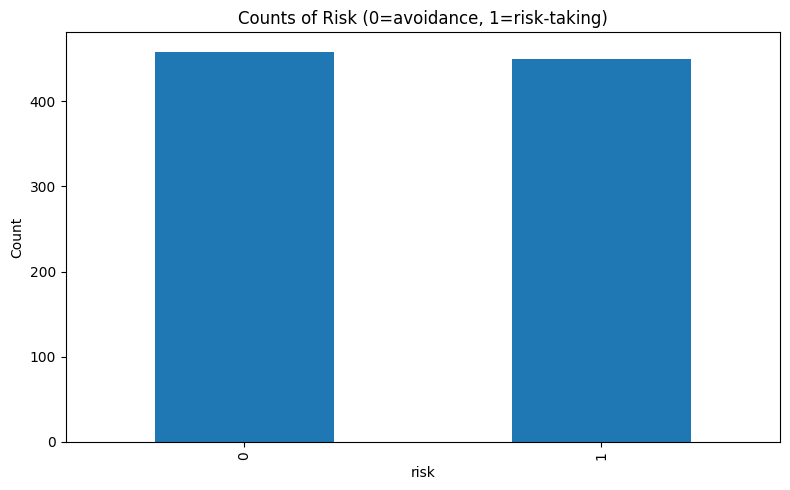

<Figure size 800x500 with 0 Axes>

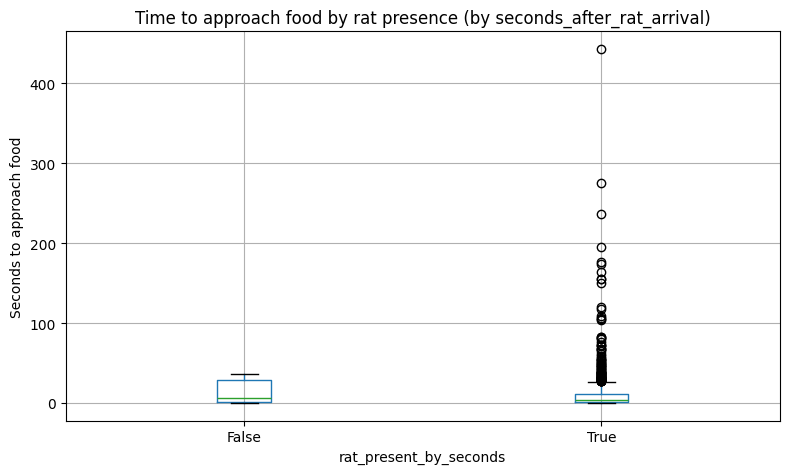

/tmp/ipython-input-1923936353.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df1.groupby('sec_bin')['risk'].mean().reset_index().rename(columns={'risk':'prop_risk'})


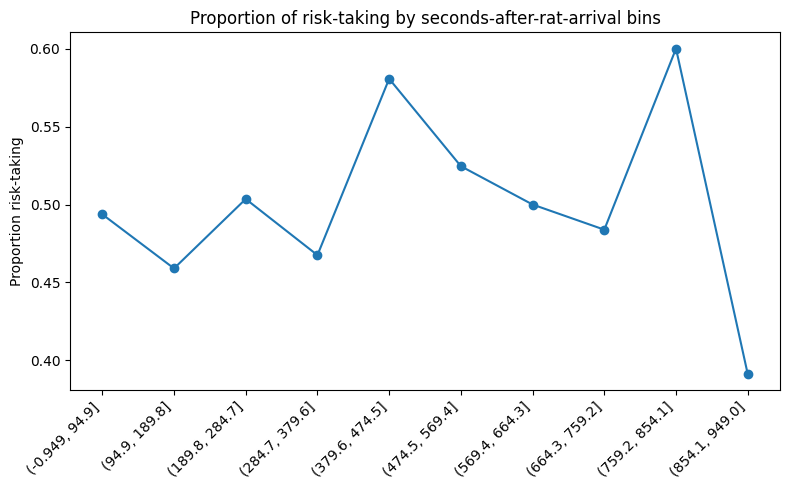

In [11]:
if 'risk' in df1.columns:
    counts = df1['risk'].value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar')
    plt.title('Counts of Risk (0=avoidance, 1=risk-taking)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('/content/risk_counts.png')
    plt.show()

if 'bat_landing_to_food' in df1.columns:
    groups = df1.groupby('rat_present_by_seconds')['bat_landing_to_food'].apply(list)
    if len(groups) == 2 and groups.index.isin([False, True]).all() and \
       len(groups[False]) >= 5 and len(groups[True]) >= 5:
        plt.figure()
        df1.boxplot(column='bat_landing_to_food', by='rat_present_by_seconds')
        plt.title('Time to approach food by rat presence (by seconds_after_rat_arrival)')
        plt.suptitle('')
        plt.ylabel('Seconds to approach food')
        plt.tight_layout()
        plt.savefig('/content/boxplot_bat_time_by_rat.png')
        plt.show()
    else:
        print("Skipping boxplot by rat presence: one group is too small or nonexistent. Use seconds_after_rat_arrival summary instead.")

if 'seconds_after_rat_arrival' in df1.columns and 'risk' in df1.columns:
    df1['sec_bin'] = pd.cut(df1['seconds_after_rat_arrival'], bins=10)
    prop = df1.groupby('sec_bin')['risk'].mean().reset_index().rename(columns={'risk':'prop_risk'})
    plt.figure()
    plt.plot(range(len(prop)), prop['prop_risk'], marker='o')
    plt.xticks(range(len(prop)), [str(x) for x in prop['sec_bin']], rotation=45, ha='right')
    plt.title('Proportion of risk-taking by seconds-after-rat-arrival bins')
    plt.ylabel('Proportion risk-taking')
    plt.tight_layout()
    plt.savefig('/content/prop_risk_by_sec_bins.png')
    plt.show()
